# 🌎 Prédiction de l'impact de sanctions économiques 🌎

# Notebook 2 - Final

![img](img/map4.jpg)

### Visualization of the data set

#### Sanctions over time
![img](img/years.png)

#### Countries that emitted the sanctions
![img](img/initiateurs1.png)

#### Countries that were targetted by the sanctions
![img](img/targets_sorted.png)

#### Duration of the sanctions
![img](img/sanctions_by_duration.png)

#### Cost of the sanction for the sender
![img](img/cost_to_sender.png)

#### Various goals are pursued by implementing sanctions
![img](img/sanctions_by_goals.png)

#### Data preparation

In [1]:
# import required libraries

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 80)
sns.set_style("whitegrid")
%matplotlib inline

np.random.seed(0)
seed=42

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
base_df = pd.read_csv("input/sanctions.csv.gz", na_values="n.a.", decimal=",")

base_df.columns

Index(['Case no.b', 'Sender c', 'Sender 2c', 'Sender 3c', 'Targetd', 'Goal',
       'US casee', 'US unilateral casef', 'Foreign policy goal categoryg',
       'First yearh', 'Last yeari', 'Policy resultj',
       'Sanctions contributionk', 'Success \nscorel', 'Companion policiesm',
       'International cooperationn', 'International assistanceo',
       'Cooperating international organizationp',
       'International organization senderq',
       'International organization sender & target membersr',
       'Length (years)s', 'Prior relationst',
       'Regime Type \n(DEMOC 1st year)u', 'Regime Type2 (Polity2 1st year)v',
       'Regime Type3 \n(Scale 1st year)w', 'Political stability priorx',
       'Political stability duringy', 'Cost to targetz',
       'Cost to target (percent of GNP)aa', 'Cost to target per capitabb',
       'Trade linkagecc', 'GNP \nratiodd', 'Health and stabilityee',
       'Sanction typeff', 'Cost to sendergg',
       'GDP growth (percent, 5-year average)hh',
 

In [3]:
# Rename columns for clarity

clean_names = [
    'Case no','Sender1', 'Sender2', 'Sender3', 'Target', 'Goal', 'US case',
    'US unilateral case', 'Foreign policy goal category', 'First year',
    'Last year','Policy result', 'Sanctions contribution',
    'Success', 'Companion policies', 'International cooperation',
    'International assistance', 'Cooperating international organization',
    'International organization sender',
    'International organization sender & target members',
    'Length', 'Prior relations',
    'Regime Type1', 'Regime Type2',
    'Regime Type3', 'Political stability prior',
    "Political stability during", 'Cost to target',
    'Cost to target GNP pct', 'Cost to target per capita',
    'Trade linkage', 'GNP ratio','Health and stability',
    'Sanction type', 'Cost to sender',
    'GDP growth',
    'Inflation',
    'Target IMF code',
    'Country group']

name_dict = dict(zip(base_df.columns, clean_names))
base_df = base_df.rename(columns=name_dict)

In [4]:
# Drop certain columns
# - information unknown at decision time
# - calculated components of success
# - information useless for prediction

unknowns = [
    "Last year",
    "Length",
    "Political stability during",
    "Cost to target",
    "Cost to target GNP pct",
    "Cost to target per capita",
    "Cost to sender"]
calculated = ["Policy result", "Sanctions contribution"]
useless = ["Case no", "Target IMF code"]

df = base_df.drop(unknowns, axis=1)
df = df.drop(calculated, axis=1)
df = df.drop(useless, axis=1)

print(df.shape)
df.head(3)

(204, 28)


,Sender1,Sender2,Sender3,Target,Goal,US case,US unilateral case,Foreign policy goal category,First year,Success,Companion policies,International cooperation,International assistance,Cooperating international organization,International organization sender,International organization sender & target members,Prior relations,Regime Type1,Regime Type2,Regime Type3,Political stability prior,Trade linkage,GNP ratio,Health and stability,Sanction type,GDP growth,Inflation,Country group
0,UNITED KINGDOM,NaN,NaN,GERMANY,Military victory,0,0,4,1914,12,R,4,A,--,0,0,1,5.0,2.0,2.0,0.0,9.0,1.0,3,"F,X,M",3.6,2.9,1
1,UNITED STATES,NaN,NaN,JAPAN,Shipping for Allies,1,1,5,1917,4,--,1,--,--,0,0,2,5.0,1.0,2.0,0.0,20.5,13.0,3,X,5.4,25.6,1
2,UNITED KINGDOM,NaN,NaN,RUSSIA,Destabilize Bolsheviks,0,0,2,1918,2,"R,Q",4,--,--,0,0,1,1.0,-1.0,2.0,0.1,18.5,1.0,1,"F,X,M",NaN,NaN,2


#### Data cleaning

In [5]:
# drop all not immediately useful columns

useless = ["Target", "Goal","Sender1","Sender2","Sender3"]

df = df.drop(useless, axis=1)

In [6]:
# Create helpers

def replace_w_dummies(dataframe, col_name, prefx):
    """Get dummy columns for a given dimension"""
    new_dataframe = pd.concat([dataframe, pd.get_dummies(df[col_name], prefix=prefx)], axis=1)
    new_dataframe.drop([col_name], axis=1, inplace=True)
    return new_dataframe

In [7]:
# Clean

df = replace_w_dummies(df, 'Foreign policy goal category', 'frgn_pol_')

df['International assistance'] = df['International assistance'].apply(lambda x: 0 if x == "--" else 1)

df["first-year_era_1"] = df["First year"].apply(lambda x: 1 * (x <= 1945))
df["first-year_era_2"] = df["First year"].apply(lambda x: 1 * (1946 <= x <= 1991))
df["first-year_era_3"] = df["First year"].apply(lambda x: 1 * (1992 <= x))
df = df.drop(["First year"], axis=1)

df["bool_success"] = 1 * (df["Success"] >= 9)
df.drop(["Success"], axis=1, inplace=True)


# Convert "Companion policies"
def rate_comp_policies(letters):
    s = 0
    if letters.find("J") >= 0:
        s += 1
    if letters.find("Q") >= 0:
        s += 1
    if letters.find("R") >= 0:
        s += 1
    return s
df["Companion policies"] = df["Companion policies"].apply(rate_comp_policies)

# Convert "Sanction type"
def rate_sanction_type(letters):
    s = 0
    if letters.find("F") >= 0:
        s += 1
    if letters.find("X") >= 0:
        s += 1
    if letters.find("M") >= 0:
        s += 1
    return s
df["Sanction type"] = df["Sanction type"].apply(rate_sanction_type)

# Make "Cooperating international organization" 1 or 0
df["bool_Cooperating international organization"] = df["Cooperating international organization"].apply(lambda x: 0 if x == "--" else 1)
df.drop(["Cooperating international organization"], axis=1, inplace=True)

In [8]:
df.head(3)

,US case,US unilateral case,Companion policies,International cooperation,International assistance,International organization sender,International organization sender & target members,Prior relations,Regime Type1,Regime Type2,Regime Type3,Political stability prior,Trade linkage,GNP ratio,Health and stability,Sanction type,GDP growth,Inflation,Country group,frgn_pol__1,frgn_pol__2,frgn_pol__3,frgn_pol__4,frgn_pol__5,first-year_era_1,first-year_era_2,first-year_era_3,bool_success,bool_Cooperating international organization
0,0,0,1,4,1,0,0,1,5.0,2.0,2.0,0.0,9.0,1.0,3,3,3.6,2.9,1,0,0,0,1,0,1,0,0,1,0
1,1,1,0,1,0,0,0,2,5.0,1.0,2.0,0.0,20.5,13.0,3,1,5.4,25.6,1,0,0,0,0,1,1,0,0,0,0
2,0,0,2,4,0,0,0,1,1.0,-1.0,2.0,0.1,18.5,1.0,1,3,NaN,NaN,2,0,1,0,0,0,1,0,0,0,0


#### Handling missing values

In [9]:
df.isna().sum()

US case                                                0
US unilateral case                                     0
Companion policies                                     0
International cooperation                              0
International assistance                               0
International organization sender                      0
International organization sender & target members     0
Prior relations                                        0
Regime Type1                                           5
Regime Type2                                           5
Regime Type3                                           5
Political stability prior                              5
Trade linkage                                          1
GNP ratio                                              0
Health and stability                                   0
Sanction type                                          0
GDP growth                                            18
Inflation                      

In [10]:
# Replace code values with more representative values
df["Regime Type1"] = df["Regime Type1"].replace({-77:-1, -88:-1})
df["Regime Type2"] = df["Regime Type2"].replace({-77:-11, -88:-11})

# Fill NaN values with most common value
df["Regime Type1"] = df["Regime Type1"].fillna(df['Regime Type1'].mode()[0]) # 0 - no democracy
df["Regime Type2"] = df["Regime Type2"].fillna(df['Regime Type2'].mode()[0]) # -7 - almost strong autocracy
df["Regime Type3"] = df["Regime Type3"].fillna(df['Regime Type3'].mode()[0]) # 1 - autocracy

# Fill NaN values with mean value
df["Political stability prior"] = df["Political stability prior"].fillna(df['Political stability prior'].mean())
df["Trade linkage"] = df["Trade linkage"].fillna(df["Trade linkage"].mean())

# Fill NaN values with mean value AND add "flag" column
df["Missing GDP growth"] = df["GDP growth"].isna().astype("float64")
df["GDP growth"] = df["GDP growth"].fillna(df['GDP growth'].mean())
df["Missing inflation"] = df["Inflation"].isna().astype("float64")
df["Inflation"] = df["Inflation"].fillna(df['GDP growth'].mean())

In [11]:
df.isna().sum()

US case                                               0
US unilateral case                                    0
Companion policies                                    0
International cooperation                             0
International assistance                              0
International organization sender                     0
International organization sender & target members    0
Prior relations                                       0
Regime Type1                                          0
Regime Type2                                          0
Regime Type3                                          0
Political stability prior                             0
Trade linkage                                         0
GNP ratio                                             0
Health and stability                                  0
Sanction type                                         0
GDP growth                                            0
Inflation                                       

#### Reminder:
- Regime Type is the value of the Polity IV variable called DEMOC, which measures the degree of democracy in the target in the 1st year of sanctions, ranging from 0 (no democracy) to 10 (strong democracy)
- Regime Type2 is the value of the Polity2 variable from the Polity IV database that allows for a country to have varying degrees of both democracy and autocracy in the target, ranging from -10 (strongly autocratic) to 10 (strongly democratic)
- Regime Type3 collapses the Polity2 data to a 3-point scale where 1 = autocracy, 2 = anocracy, and 3 = democracy.

### Feature engineering

In [12]:
def oecd_la(row):
    if row == 1 or row == 3:
        oecd_la=1
    else:
        oecd_la=0
    return oecd_la

# country group [OCDE + LA] vs others.
# Hypothesis: since OCDE members abide by international law, sanctions hit them harder

df['oecd_la'] = df["Country group"].apply(oecd_la)
df = df.drop(["Country group"], axis=1)

In [13]:
# Try dropping highly correlated features
# => doesn't improve perf

#df = df.drop(["Regime Type1","Regime Type3"], axis=1)

In [14]:
# change type to float64 for all columns
df = df.astype(np.float64)

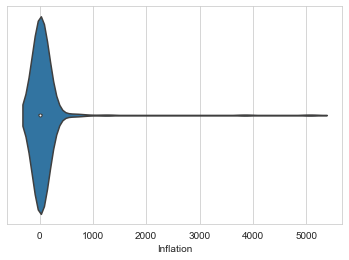

In [15]:
sns.violinplot(df["Inflation"])

In [16]:
# pd.qcut(df['Inflation'], q=4).value_counts()

In [17]:
df['GDPgrowthgroup'] = pd.cut(df['GDP growth'], bins=[-20,-5,5,40], labels=["Low", "Mid", "High"])
df = pd.concat([df, pd.get_dummies(df['GDPgrowthgroup'], prefix='GDPGrowth_')], axis=1)

df['Inflation'] = pd.cut(df['Inflation'], bins=[-5,-3.1, 8.7, 17.9,6000], labels=["Low", "Mid", "High", "Very high"])
df = pd.concat([df, pd.get_dummies(df['Inflation'], prefix='Inflation_')], axis=1)


df.drop(['GDPgrowthgroup', 'Inflation'], axis=1, inplace=True)

In [18]:
df.head(10)

,US case,US unilateral case,Companion policies,International cooperation,International assistance,International organization sender,International organization sender & target members,Prior relations,Regime Type1,Regime Type2,Regime Type3,Political stability prior,Trade linkage,GNP ratio,Health and stability,Sanction type,GDP growth,frgn_pol__1,frgn_pol__2,frgn_pol__3,frgn_pol__4,frgn_pol__5,first-year_era_1,first-year_era_2,first-year_era_3,bool_success,bool_Cooperating international organization,Missing GDP growth,Missing inflation,oecd_la,GDPGrowth__Low,GDPGrowth__Mid,GDPGrowth__High,Inflation__Low,Inflation__Mid,Inflation__High,Inflation__Very high
0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,1.0,5.0,2.0,2.0,0.0,9.0,1.0,3.0,3.0,3.600000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0,0,1,0,0
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,5.0,1.0,2.0,0.0,20.5,13.0,3.0,1.0,5.400000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,0,0,0,1
2,0.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,-1.0,2.0,0.1,18.5,1.0,1.0,3.0,3.184946,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,1,0,0,1,0,0
3,0.0,0.0,0.0,4.0,0.0,1.0,1.0,2.0,3.0,0.0,2.0,0.4,26.5,37.0,2.0,0.0,-1.500000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,0,0,1,0,0
4,0.0,0.0,0.0,4.0,0.0,1.0,1.0,2.0,0.0,-6.0,1.0,0.9,36.0,56.0,2.0,0.0,3.300000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0,0,0,0,1
5,0.0,0.0,0.0,3.0,0.0,1.0,1.0,2.0,4.0,2.0,2.0,0.0,63.0,322.0,2.0,1.0,3.184946,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0,1,0,0,1,0,0
6,0.0,0.0,0.0,3.0,0.0,1.0,1.0,2.0,1.0,-3.0,2.0,0.0,59.5,735.0,2.0,1.0,3.184946,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0,1,0,0,1,0,0
7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-9.0,1.0,0.0,13.0,1.0,2.0,1.0,2.400000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,0,0,1,0,0
8,0.0,0.0,0.0,4.0,1.0,1.0,1.0,2.0,0.0,-9.0,1.0,0.3,16.0,6.0,3.0,3.0,-0.500000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,1,0,0,0
9,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,-6.0,1.0,0.1,69.5,75.0,3.0,2.0,7.400000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,1,0,1,0,0


#### Modelization

In [19]:
# Split dataset into train / test sets

Y = df['bool_success']
X = df.drop(['bool_success'],axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=seed+1, stratify=Y)

print("Train size", x_train.shape[0])
print("Test size", x_test.shape[0])
print("Number of parameters", x_train.shape[1])

Train size 153
Test size 51
Number of parameters 36


In [20]:
# Create pipelines for modelization, and define hyperparameters to be used.

# Pipelines 

pipelines = {
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state = seed)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state = seed)),
    'l1' : make_pipeline(StandardScaler(), LogisticRegression(penalty = 'l1', random_state=seed, solver='saga', max_iter=300)),
    'l2' : make_pipeline(StandardScaler(), LogisticRegression(penalty = 'l2', random_state=seed, solver='saga', max_iter=300))}

# Hyperparameters

rf__hyperparameters = {
    'randomforestclassifier__n_estimators' : [100, 200],
    'randomforestclassifier__max_features' : ['auto', 'sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf' : [1, 3, 5, 10]
}

gb__hyperparameters = {
    'gradientboostingclassifier__n_estimators' : [100, 200],
    'gradientboostingclassifier__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth' : [1, 3, 5, 10]
}

l1__hyperparameters = {
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}

l2__hyperparameters = {
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}

hyperparameters = { 
    'rf' : rf__hyperparameters,
    'gb' : gb__hyperparameters,
    'l1' : l1__hyperparameters,
    'l2' : l2__hyperparameters
}

In [21]:
# Create models for all the hyper-parameters combinations

models = {}

for name, pipeline in pipelines.items() :    
    model = GridSearchCV(pipeline, hyperparameters[name], cv=5, n_jobs=-1, iid=False)      
    model.fit(x_train, y_train)    
    models[name] = model     
    print(f'{name} has been fitted')

rf has been fitted
gb has been fitted
l1 has been fitted
l2 has been fitted


In [22]:
# Evaluation performance
# => show accuracy (other metrics will be needed) for each model

for key in models.keys():
    train_preds = models[key].predict(x_train)
    test_preds = models[key].predict(x_test)
    train_accuracy = np.round(metrics.accuracy_score(y_train, train_preds),2)
    test_accuracy = np.round(metrics.accuracy_score(y_test, test_preds),2)
    print("Accuracy for" ,key ,"on train:", train_accuracy,"and on test:", test_accuracy)

Accuracy for rf on train: 0.7 and on test: 0.71
Accuracy for gb on train: 0.71 and on test: 0.69
Accuracy for l1 on train: 0.65 and on test: 0.67
Accuracy for l2 on train: 0.76 and on test: 0.67


#### Exploration of errors

In [23]:
def print_metrics(model, y, x, label='model name', best_estimator=False):
    """Display Confusion matrix and accuracy for a given model.
    May display 'best estimator' paramater values"""
   
    preds = model.predict(x)
        
    print(f'Confusion matrix for: {label}')
    
    if best_estimator == True:
        print(model.best_estimator_)
        
    print('Accuracy:', np.round(metrics.accuracy_score(y, preds),2))
    
    m = metrics.confusion_matrix(y, preds)
    
    ax = sns.heatmap(m, annot=True, fmt='.0f', cbar=False, cmap="Blues", yticklabels=['Fail','Success'], xticklabels=['Fail','Success'])
    ax.set(xlabel='Predicted', ylabel='True')
    plt.show()

Confusion matrix for: l2
Accuracy: 0.71


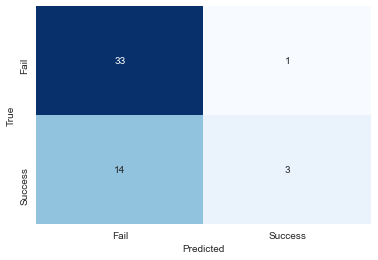

In [24]:
print_metrics(models['rf'], y_test, x_test, label='l2')

In [25]:
preds = models['rf'].predict(x_test)

new = base_df.loc[y_test.index]

new["sanction_success_bool"] = new["Success"].apply(lambda x: x >= 9).astype("float64")
new["preds"] = preds

new[new["sanction_success_bool"] != new["preds"]]

,Case no,Sender1,Sender2,Sender3,Target,Goal,US case,US unilateral case,Foreign policy goal category,First year,Last year,Policy result,Sanctions contribution,Success,Companion policies,International cooperation,International assistance,Cooperating international organization,International organization sender,International organization sender & target members,Length,Prior relations,Regime Type1,Regime Type2,Regime Type3,Political stability prior,Political stability during,Cost to target,Cost to target GNP pct,Cost to target per capita,Trade linkage,GNP ratio,Health and stability,Sanction type,Cost to sender,GDP growth,Inflation,Target IMF code,Country group,sanction_success_bool,preds
90,77-5,UNITED STATES,NaN,NaN,NICARAGUA,Destabilize Somoza,1,1,2,1977,1979,4,3,12,--,1,--,--,0,0,2,3,0.0,-8.0,1.0,0.0,0.0,22,1,"9,48",26.50,913.00,1,"F,X",1,5.6,7.9,278,3,1.0,0.0
118,83-1,AUSTRALIA,NaN,NaN,FRANCE,Nuclear testing,0,0,1,1983,1986,1,2,2,--,1,--,--,0,0,3,3,0.0,8.0,3.0,0.0,0.0,"0,001","0,001","0,001",0.50,0.30,3,X,2,2.4,13.0,132,1,0.0,1.0
61,65-3,UNITED NATIONS,UNITED KINGDOM,NaN,RHODESIA,Majority rule,1,0,2,1965,1979,4,3,12,Q,4,A,OAU,1,0,14,3,7.0,4.0,2.0,0.1,0.0,130,13,"28,89",68.50,1388.00,2,"F,X,M",3,3.8,NaN,698,6,1.0,0.0
189,95-2,EUROPEAN UNION,NaN,NaN,TURKEY,Human rights,0,0,2,1995,1995,3,3,9,--,1,--,--,1,0,1,3,9.0,8.0,3.0,0.0,0.0,"0,001","0,001","0,001",53.00,48.70,2,"F,X,M",2,3.7,80.8,186,1,1.0,0.0
155,91-4,UNITED STATES,NETHERLANDS,NaN,INDONESIA,Independence for East Timor,1,0,5,1999,2002,3,4,12,--,3,--,"UN, EU",0,1,3,2,0.0,-5.0,2.0,0.1,0.0,"316,5","0,2","1,53",18.00,75.10,1,"F,X",2,3.0,24.1,536,5,1.0,0.0
194,96-5,UNITED STATES,MERCOSUR,NaN,PARAGUAY,Possible coup attempt,1,0,2,1996,1996,4,3,12,--,3,--,OAS,1,1,1,3,7.0,7.0,3.0,0.2,0.0,--,--,--,61.55,902.00,2,--,1,3.2,17.4,288,3,1.0,0.0
12,39-1,UNITED STATES,ALLIANCE POWERS,NaN,"GERMANY, (JAPAN)",Military victory,1,0,4,1939,1945,4,3,12,R,4,--,--,0,0,6,1,0.0,-9.0,1.0,0.1,0.0,400,"1,41","5,77",10.80,3.11,3,"F,X,M",4,7.8,0.8,134,1,1.0,0.0
65,70-1,UNITED STATES,NaN,NaN,CHILE,Destabilize Allende,1,1,2,1970,1973,4,3,12,J,1,--,--,0,0,3,2,0.0,6.0,3.0,0.0,0.0,163,"1,5","17,16",16.50,102.00,1,F,1,4.3,25.2,228,3,1.0,0.0
145,90-2,UNITED STATES,NaN,NaN,EL SALVADOR,"Human rights, end civil war",1,1,2,1990,1993,3,3,9,--,1,--,--,0,0,3,3,6.0,6.0,3.0,0.4,0.0,58,"1,3","11,15",37.50,1256.00,1,F,1,1.2,20.8,253,3,1.0,0.0
178,93-3,UNITED NATIONS,NaN,NaN,"ANGOLA, UNITA","Civil war, democracy",1,0,5,1993,2002,4,3,12,R,4,--,--,1,0,9,2,0.0,-10.0,1.0,0.0,0.0,105,"7,5","32,81",80.00,11221.00,1,"F,X,M",2,-0.5,191.4,614,6,1.0,0.0


### Correlation

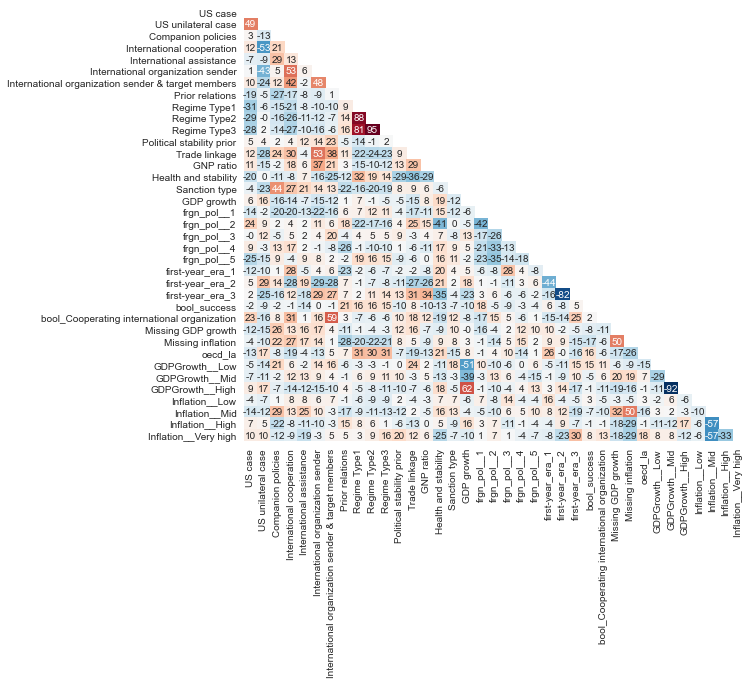

In [26]:
correlations = df.corr() * 100

cleanning_mask = np.zeros_like(correlations)
upper_triangle = np.triu_indices_from(correlations)
cleanning_mask[upper_triangle] = 1

plt.figure(figsize=(9,8))

sns.heatmap(correlations, cmap = 'RdBu_r', mask = cleanning_mask, annot=True, fmt='.0f', cbar=False )

In [27]:
# Chose variables with the highest correlation to bool_success

corr_floor = 5

# Correlation with output variable
cor_target = abs(correlations["bool_success"])

# Selecting highly correlated features
correlated_features = cor_target[cor_target > corr_floor]
correlated_features

US unilateral case             9.456569
International assistance      14.132749
Prior relations               20.904206
Regime Type1                  16.075939
Regime Type2                  16.168285
Regime Type3                  15.387678
Political stability prior      9.532292
Trade linkage                  7.782356
GNP ratio                      9.527907
Health and stability          13.280366
Sanction type                  6.542352
GDP growth                    10.076935
frgn_pol__1                   18.341120
frgn_pol__2                    5.183376
frgn_pol__3                    8.951566
first-year_era_1               5.798430
first-year_era_2               7.559061
bool_success                 100.000000
Missing GDP growth             7.922985
Missing inflation             17.490442
oecd_la                       16.142130
GDPGrowth__Low                14.736431
Inflation__Mid                 6.844293
Inflation__Very high           8.345762
Name: bool_success, dtype: float64

In [28]:
correlated = correlated_features.index.to_list()
correlated.remove('bool_success')

#### Reffiting de modèle avec les features sélectionnées

In [29]:
correlated_models = {}

for name, pipeline in pipelines.items() :
    
    model = GridSearchCV(pipeline, hyperparameters[name], cv=5, n_jobs=-1, iid=False)      
    model.fit(x_train[correlated], y_train)
    
    correlated_models[name] = model     
    print(f'{name} has been fitted')

rf has been fitted
gb has been fitted
l1 has been fitted
l2 has been fitted


In [30]:
for key in models.keys():
    train_preds = correlated_models[key].predict(x_train[correlated])
    test_preds = correlated_models[key].predict(x_test[correlated])
    train_accuracy = np.round(metrics.accuracy_score(y_train, train_preds),2)
    test_accuracy = np.round(metrics.accuracy_score(y_test, test_preds),2)
    print("Accuracy for" ,key ,"on train:", train_accuracy,"and on test:", test_accuracy)

Accuracy for rf on train: 0.74 and on test: 0.75
Accuracy for gb on train: 0.71 and on test: 0.69
Accuracy for l1 on train: 0.65 and on test: 0.67
Accuracy for l2 on train: 0.74 and on test: 0.71


#### Study feature importance

In [31]:
from sklearn.feature_selection import SelectKBest, f_classif

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(x_train, y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x_train.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                       Specs     Score
17               frgn_pol__1  8.041090
7            Prior relations  7.547244
13                 GNP ratio  3.348370
4   International assistance  2.844675
29            GDPGrowth__Low  2.844675
1         US unilateral case  2.844675
27         Missing inflation  2.653577
28                   oecd_la  1.953296
32            Inflation__Low  1.897939
14      Health and stability  1.890747


In [32]:
feature_score=featureScores.nlargest(10,'Score')
new_features_set=feature_score['Specs'].to_list()

In [33]:
restricted_models = {}

for name, pipeline in pipelines.items() :
    
    model = GridSearchCV(pipeline, hyperparameters[name], cv=5, n_jobs=-1, iid=False)      
    model.fit(x_train[new_features_set], y_train)
    
    restricted_models[name] = model     
    print(f'{name} has been fitted')
    
for key in models.keys():
    train_preds = restricted_models[key].predict(x_train[new_features_set])
    test_preds = restricted_models[key].predict(x_test[new_features_set])
    train_accuracy = np.round(metrics.accuracy_score(y_train, train_preds),2)
    test_accuracy = np.round(metrics.accuracy_score(y_test, test_preds),2)
    print("Accuracy for" ,key ,"on train:", train_accuracy,"and on test:", test_accuracy)

rf has been fitted
gb has been fitted
l1 has been fitted
l2 has been fitted
Accuracy for rf on train: 0.78 and on test: 0.71
Accuracy for gb on train: 0.69 and on test: 0.67
Accuracy for l1 on train: 0.72 and on test: 0.71
Accuracy for l2 on train: 0.73 and on test: 0.71


#### ROC curves

In [36]:
def plot_roc(model_name):
    preds = restricted_models[model_name].predict(x_test[new_features_set])

    fpr, tpr, thresholds = roc_curve(y_test, preds)
    pd.DataFrame({'FPR': fpr, 'TPR' : tpr, 'Thresholds' : thresholds})
    plt.figure(figsize=(10, 10))
    plt.title('Receiver Operating Curve')

    plt.plot(fpr, tpr, label=model_name)
    plt.legend(loc='lower right')

    plt.plot([0,1], [0,1], 'k--')
    
# for model_name in restricted_models.keys():
#     plot_roc(model_name)
# plt.show()